<a href="https://colab.research.google.com/github/MingshuoYu/DATA228/blob/master/Roboflow_Yolov3_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTE: for the most up to date version of this notebook, please copy from

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ntAL_zI68xfvZ4uCSAF6XT27g0U4mZbW#scrollTo=VHS_o3KGIyXm)




## **Training YOLOv3 object detection on a custom dataset**

PyTorch Edition! Thanks to [Ultralytics](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) for making this simpler.

### **Overview**

This notebook walks through how to train a YOLOv3 object detection model on your own dataset using Roboflow and Colab.

In this specific example, we'll training an object detection model to recognize chess pieces in images. **To adapt this example to your own dataset, you only need to change one line of code in this notebook.**

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full).

### **Our Model**

We'll be training a YOLOv3 (You Only Look Once) model. This specific model is a one-shot learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant, viewing up to 60 frames per second in predicting against video feeds.

The GitHub repo containing the majority of the code we'll use is available [here](https://github.com/roboflow-ai/yolov3).

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

We'll leverage the `detect.py --weights weights/last.pt` script to produce predictions. Arguments are specified below.

### **About**

[Roboflow](https://roboflow.ai) makes managing, preprocessing, augmenting, and versioning datasets for computer vision seamless.

Developers reduce 50% of their boilerplate code when using Roboflow's workflow, save training time, and increase model reproducibility.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)








In [1]:
import os
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [2]:
!git clone https://github.com/roboflow-ai/yolov3  # clone

Cloning into 'yolov3'...
remote: Enumerating objects: 8443, done.
remote: Total 8443 (delta 0), reused 0 (delta 0), pack-reused 8443
Receiving objects: 100% (8443/8443), 6.89 MiB | 26.33 MiB/s, done.
Resolving deltas: 100% (5825/5825), done.


## Get Data from Roboflow

Create an export from Roboflow. **Select "YOLO Darknet" as the export type.**

Our labels will be formatted to our model's architecture.

In [4]:
# REPLACE THIS LINK WITH YOUR OWN

!curl -L "https://app.roboflow.com/ds/k4yrsbjCcP?key=wreU3IZLBp" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/Japan_006419_jpg.rf.f9e1c51c07ce69499d03ec372ec7edb5.jpg  
 extracting: train/Japan_006420_jpg.rf.97a2647623577f4d04d0a582f78c638b.jpg  
 extracting: train/Japan_006423_jpg.rf.1be40323dc920542eb75e2f78380f905.jpg  
 extracting: train/Japan_006427_jpg.rf.3af30e224b25873c0d8f79488f16bda6.jpg  
 extracting: train/Japan_006429_jpg.rf.fd277bd3abe63bd553d69a1d22a5f565.jpg  
 extracting: train/Japan_006430_jpg.rf.d1029ebe8a5488e37bc23c82c984b7fd.jpg  
 extracting: train/Japan_006431_jpg.rf.3d640372c4bf840bcbbc9123f6e26958.jpg  
 extracting: train/Japan_006434_jpg.rf.906ffb1d7ec770b782952588ef7d558a.jpg  
 extracting: train/Japan_006436_jpg.rf.4cb430aa5ab2cfe2f37c124ef6bb240d.jpg  
 extracting: train/Japan_006437_jpg.rf.9829495df943884d76688bcd7d33c2d5.jpg  
 extracting: train/Japan_006438_jpg.rf.d29a2dca430161db48d773601e4969fc.jpg  
 extracting: train/Japan_006439_jpg.rf.3ff2ab2dc3432fe73eccec25f3b59984.jpg  
 extracting: 

## Organize data and labels for Ultralytics YOLOv3 Implementation

Ultalytics's implemention of YOLOv3 calls for [a specific file management](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data) where our images are in a folder called `images` and corresponding labels in a folder called `labels`. The image and label names must match identically. Fortunately, our files are named appropriately from Roboflow.

We need to reorganize the folder structure slightly.

In [5]:
%cd train

/content/train


In [6]:
%ls

_annotations.txt
_classes.txt
Japan_000000_jpg.rf.f13bba36aa46327850e3bced4dbcf955.jpg
Japan_000002_jpg.rf.598256c8b36e6632cc4633b7828eddce.jpg
Japan_000003_jpg.rf.cc3114438c0c3abb10aa3c4d3cedbe67.jpg
Japan_000005_jpg.rf.ca47f522084a6874daab356118f0b810.jpg
Japan_000008_jpg.rf.0266aa5c4db66113a3cb41333822c5b1.jpg
Japan_000010_jpg.rf.b72e05d771c9981ff3261a278363122d.jpg
Japan_000012_jpg.rf.810fddfa0051fec35367e0578419cd40.jpg
Japan_000014_jpg.rf.75506b9ae93620af7dce44460ba3e61b.jpg
Japan_000017_jpg.rf.668a18c65a945f5b21c8d592b9b537ca.jpg
Japan_000022_jpg.rf.2fcf86df02e96d095ceaedb0703d9d74.jpg
Japan_000024_jpg.rf.2ec1b7205acce87d6dabfd7a5b21ecef.jpg
Japan_000027_jpg.rf.c7b8f40175768737adabe108cb811e45.jpg
Japan_000030_jpg.rf.97bb32c83d7e19d05ec71cb3c726352c.jpg
Japan_000032_jpg.rf.744d93c1a56d307f4485ff757cfce0d6.jpg
Japan_000033_jpg.rf.b442b66a69457ee024faf2aad0122725.jpg
Japan_000035_jpg.rf.97014b4c87900853eb58fbc5b0d0b8b7.jpg
Japan_000036_jpg.rf.6257940160c9d8f0093db82e6ae7d80b.jpg
J

In [7]:
%mkdir labels
%mkdir images

In [8]:
%mv *.jpg ./images/
%mv *.txt ./labels/

In [9]:
%cd images

/content/train/images


In [10]:
# create Ultralytics specific text file of training images
file = open("train_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "train_images_roboflow.txt":
        pass
      else:
        file.write("../train/images/" + filename + "\n")
file.close()

In [11]:
%cat train_images_roboflow.txt

../train/images/Japan_012291_jpg.rf.efa8f02fec08f5e292aa09451aba4960.jpg
../train/images/Japan_012268_jpg.rf.a2416d615984a1b994022e1369da9ef3.jpg
../train/images/Japan_003129_jpg.rf.94565e91a790248114ac7cd59f5e964e.jpg
../train/images/Japan_004898_jpg.rf.777657b8bb7f8d5f2123badea3925341.jpg
../train/images/Japan_008915_jpg.rf.630eef2ac0d04bcc053b78e41ff22a34.jpg
../train/images/Japan_004309_jpg.rf.89eff1c8c1833e220c96b0cdce71db1d.jpg
../train/images/Japan_007509_jpg.rf.8e18295293ac0a8c84a631bcf83f9dce.jpg
../train/images/Japan_003419_jpg.rf.6a77dd66f1596bc89a8b53f6a281213f.jpg
../train/images/Japan_004014_jpg.rf.d2262ead8f6b82cd84a15f02606bbe75.jpg
../train/images/Japan_010586_jpg.rf.976294aaafe7feb43438ec7d2ba13906.jpg
../train/images/Japan_003752_jpg.rf.41bc3f490b75856ad6a5f6de037905e6.jpg
../train/images/Japan_009651_jpg.rf.80e3f5c2b8f80c88badeef457c99894a.jpg
../train/images/Japan_009858_jpg.rf.fb50a692adb1194da0d517f3dba510dd.jpg
../train/images/Japan_003950_jpg.rf.fb8333a0e71c198

In [12]:
%cd ../../valid

/content/valid


In [13]:
%mkdir labels
%mkdir images

In [14]:
%mv *.jpg ./images/
%mv *.txt ./labels/

In [15]:
%cd images

/content/valid/images


In [16]:
# create Ultralytics specific text file of validation images
file = open("valid_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "valid_images_roboflow.txt":
        pass
      else:
        file.write("../valid/images/" + filename + "\n")
file.close()

In [17]:
%cat valid_images_roboflow.txt

../valid/images/Japan_003933_jpg.rf.9e3f0a14a530ed3b24f4c819a8df6bc1.jpg
../valid/images/Japan_012417_jpg.rf.588f2170e58116b55b4892bbe86cce6f.jpg
../valid/images/Japan_012196_jpg.rf.263b7875e80bce77d84b3d4143da4fd3.jpg
../valid/images/Japan_011580_jpg.rf.d7aa0991f3eb05d7dd9b72db4ee810ec.jpg
../valid/images/Japan_008080_jpg.rf.cedb152132dec83331beee84d1c34072.jpg
../valid/images/Japan_011913_jpg.rf.dbb2d364418d2fe1911aa2109a338f8b.jpg
../valid/images/Japan_005320_jpg.rf.cedaf39849983e38876296cf53490b90.jpg
../valid/images/Japan_008803_jpg.rf.26a7091a78b252fd83c07ab67bc65446.jpg
../valid/images/Japan_010399_jpg.rf.d39eefb2ef5ed4027a1827fd0440b957.jpg
../valid/images/Japan_008491_jpg.rf.35fc54e58760623927f1546fadc7efda.jpg
../valid/images/Japan_011062_jpg.rf.adbef98141c3f6f4aaba3d42cc66a3ae.jpg
../valid/images/Japan_010385_jpg.rf.92ac7a186ea52e7ca15ea9fb82a35c08.jpg
../valid/images/Japan_008976_jpg.rf.6fd7792ca69819d85f8e57cdad16e754.jpg
../valid/images/Japan_010538_jpg.rf.f72bc30f89298d9

## Set up model config

We should configure our model for training.

This requires editing the `roboflow.data` file, which tells our model where to find our data, our numbers of classes, and our class label names.

Our paths for our labels and images are correct.

But we need to update our class names. That's handled below..




In [18]:
%cd ../../yolov3/data

/content/yolov3/data


In [20]:
# display class labels imported from Roboflow
%cat ../../train/labels/_classes.txt

D00
D10
D20
D40
D43
D44
D50

In [22]:
# convert .labels to .names for Ultralytics specification
%cat ../../train/labels/_classes.txt > ../../train/roboflow_data.names

In [23]:
def get_num_classes(labels_file_path):
    classes = 0
    with open(labels_file_path, 'r') as f:
      for line in f:
        classes += 1
    return classes

In [25]:
# update the roboflow.data file with correct number of classes
import re

num_classes = get_num_classes("../../train/labels/_classes.txt")
with open("roboflow.data") as f:
    s = f.read()
with open("roboflow.data", 'w') as f:
    
    # Set number of classes num_classes.
    s = re.sub('classes=[0-9]+',
               'classes={}'.format(num_classes), s)
    f.write(s)

In [26]:
# display updated number of classes
%cat roboflow.data

classes=7
train=../train/images/train_images_roboflow.txt
valid=../valid/images/valid_images_roboflow.txt
names=../train/roboflow_data.names


## Training our model

Once we have our data prepped, we'll train our model using the train script.

By default, this script trains for 300 epochs.

In [27]:
%cd ../

/content/yolov3


In [28]:
!python3 train.py --data data/roboflow.data --epochs 300

Namespace(accumulate=4, adam=False, batch_size=16, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='data/roboflow.data', device='', epochs=300, evolve=False, img_size=[416], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, var=None, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15109MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
Traceback (most recent call last):
  File "train.py", line 433, in <module>
    train()  # train normally
  File "train.py", line 104, in train
    attempt_download(weights)
  File "/content/yolov3/models.py", line 487, in attempt_download
    raise Exception(msg)
Exception: weights/yolov3-spp-ultralytics.pt missing, try downloading from https://drive.google.com/open?id=1LezFG5g3BCW6iYaV89B2i64cqEUZD7e0


## Display training performance

We'll use a default provided script to display image results. **For example:**

![example results](https://user-images.githubusercontent.com/26833433/63258271-fe9d5300-c27b-11e9-9a15-95038daf4438.png)

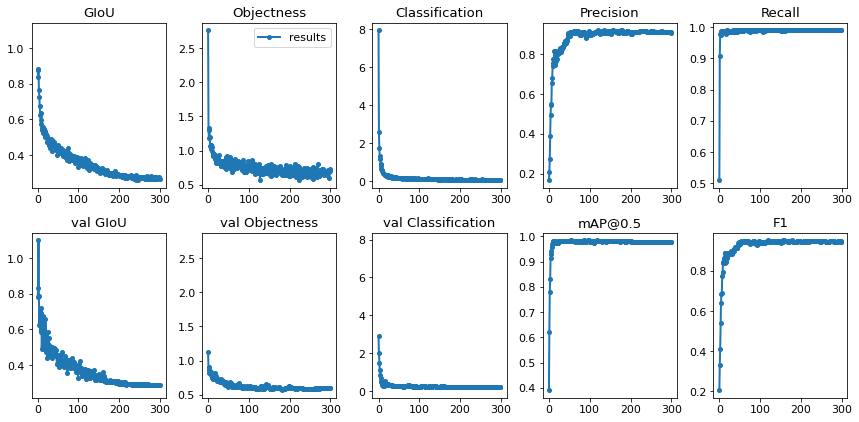

In [ ]:
from utils import utils; utils.plot_results()

## Conduct inference and display results



### Conduct inference

The below script has a few key arguments we're using:
- **Weights**: we're specifying the weights to use for our model should be those that we most recently used in training
- **Source**: we're specifying the source images we want to use for our predictions
- **Names**: we're defining the names we want to use. Here, we're referencing `roboflow_data.names`, which we created from our Roboflow `_darknet.labels`italicized text above.

In [ ]:
!python3 detect.py --weights weights/last.pt --source=../test --names=../train/roboflow_data.names

### Displaying our results

Ultralytics generates predictions which include the labels and bounding boxes "printed" directly on top of our images. They're saved in our `output` directory within the YOLOv3 repo we cloned above.

In [ ]:
# import libraries for display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from glob import glob
import random
import PIL

In [ ]:
# plot just one random image prediction
filename = random.choice(os.listdir('./output'))
print(filename)
Image('./output/' + filename)

In [ ]:
# grab all images from our output directory
images = [ PIL.Image.open(f) for f in glob('./output/*') ]

In [ ]:
# convert images to numPy
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

In [ ]:
# create array of numPy images
np_images = [ img2array(im) for im in images ]

In [ ]:
# plot ALL results in test directory (NOTE: adjust figsize as you please)
for img in np_images:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)

## Save Our Weights

We can save the weights of our model to use them for inference in the future, or pick up training where we left off. 

We can first save them locally. We'll connect our Google Drive, and save them there.


In [ ]:
# save locally
from google.colab import files
files.download('./weights/last.pt')

In [ ]:
# connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%pwd

In [ ]:
# create a copy of the weights file with a datetime 
# and move that file to your own Drive
%cp ./weights/last.pt ./weights/last_copy.pt
%mv ./weights/last_copy.pt /content/gdrive/My\ Drive